Imports

In [7]:
import gym
import numpy as np
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

Our functions

In [8]:
from Train_policy_func import Policy, load_policy
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores, plot_suboptimality_three_policies, plot_scores_RLHF
from OPPO import baseline_CartPole_v0_Fla, OPPO_update, set_seed
from PPO import evaluate_policy
from pairs_generator import sample_preference_pairs
from DPO import DPO_training



beta by default 0.5


Creating policies and changing seeds:

In [9]:
# env 1: CartPole-v0
env_name='CartPole-v0'
env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

baseline = baseline_CartPole_v0_Fla
target_score = 190 # for CartPole-v0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Hyperparams for OPPO ──
lr_oppo                 = 0.003
n_episodes              = 1200 # keep same “number of iterations” for fair comparison
max_t                   = 500  # cap on steps per episode
print_every             = 50   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99


# ── Options for the Run ──
load_policies   = True
evaluate_pi_ref = False
plot_scores     = False
n_eval          = 100

Policy_list     = []
seeds_list      = [35, 42, 100]

for seed in seeds_list:
    set_seed(seed, env)

    if load_policies:
        print(fr"Loading pi_1 and pi_2 with {seed=}")
        pi_1 = load_policy(f"./Policies/pi1_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)

    else:
        print(f"Training pi_1 and pi_2 with seed {seed}")

        pi_1 = Policy(state_size=obs_dim, action_size=action_dim).to(device)
        opt1 = torch.optim.Adam(pi_1.parameters(), lr=lr_oppo)


        scores_oppo = OPPO_update(
            policy          = pi_1,
            optimizer       = opt1,
            env             = env,
            baseline        = baseline,
            n_episodes      = n_episodes,
            max_t           = max_t,
            gamma           = gamma,      # you can reuse your PPO γ
            print_every     = print_every,
            early_stop      = False,
            seed            = seed,
            target_score    = target_score,
            env_name        = env_name,
            display_every   = False
        )


        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
    Policy_list.append([pi_1, pi_2])
    # print("------------------------------------------------------")

print("=================================")


Loading pi_1 and pi_2 with seed=35
Loading pi_1 and pi_2 with seed=42
Loading pi_1 and pi_2 with seed=100


## Evaluations of the reference policies pi_1 and pi_2

In [10]:
if evaluate_pi_ref:# ── Evaluate the policies ──
  print("Evaluating pi_1 and pi_2 for all seeds: \n")
  for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
      
      print(f"Evaluating pi_1 and pi_2 with {seed=} over {n_eval} episodes")
      # Evaluate the policies
      seed_eval = seed+32
      _, pi1_rewards = evaluate_policy(pi_1, env, n_episodes=n_eval, seed=seed_eval)
      _, pi2_rewards = evaluate_policy(pi_2, env, n_episodes=n_eval, seed=seed_eval)
      print(f"Evaluations over {n_eval} episodes done for both policies, using the seed {seed}")
      print(f"pi_1({seed}) \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
      print(f"pi_2({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")

      if plot_scores:
          plot_Scores(
              pi1_rewards,
              pi2_rewards,
          )
      print("------------------------------------------------------")


  print("=================================")

## We now implement DPO to train a new policy with the help of pi_1|2

Choose freely n_pairs to try different size for the preference dataset

In [11]:
# ── Hyperparams for DPO ──
n_pairs         = 200
lr_DPO          = 0.01
beta            = 0.5
print_dpo        = 30
n_epochs_dpo     = 300

load_pi_dpo     = True
load_from_pi2   = True
evaluate_pi_DPO = False
plot_scores     = False
Policy_DPO_list = []

for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
    if load_pi_dpo:
        print(f"Loading pi_DPO with {seed=} for the environment {env_name}")
        policy_DPO = load_policy(f"./Policies/pi_DPO_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pairs}.pth", obs_dim, action_dim, device)
    else:
        print(f"Beginning DPO with {seed=}")
        prefs = sample_preference_pairs(pi_1, pi_2, env, K=n_pairs) # Need to define K elsewhere as hyperparameter
        print(f"Collected {len(prefs)} preference pairs.")

        policy_DPO=Policy(state_size=obs_dim, action_size=env.action_space.n).to(device)
        if load_from_pi2:
            policy_DPO.load_state_dict(torch.load(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth"))
        opt_DPO    = torch.optim.Adam(policy_DPO.parameters(), lr=lr_DPO)


        DPO_training(policy_DPO, pi_1, prefs, beta, opt_DPO, nb_epochs=n_epochs_dpo)
        torch.save(policy_DPO.state_dict(), f"./Policies/pi_DPO_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pairs}.pth")
        print(f"Saved final policy as ./Policies/pi_DPO_{env_name}_seed_{seed}_beta{beta}_Npairs_{n_pairs}.pth")
    
    Policy_DPO_list.append(policy_DPO)
    if evaluate_pi_DPO:
        print(f"Evaluating pi_DPO with {seed=}, {beta=} over {n_eval} episodes")
        # Evaluate the policies
        seed_eval = seed+32
        _, pi1_rewards     = evaluate_policy(pi_1,       env, n_episodes=n_eval, seed=seed_eval)
        _, pi_dpo_rewards   = evaluate_policy(policy_DPO, env, n_episodes=n_eval, seed=seed_eval)
        _, pi2_rewards      = evaluate_policy(pi_2,       env, n_episodes=n_eval, seed=seed_eval)
        print(f"Evaluations over {n_eval} episodes using the evalutation seed {seed_eval}")
        print(f"pi_1({seed})    \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
        print(f"pi_INIT({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
        print(f"pi_DPO({seed})  \t mean reward: \t {np.mean(pi_dpo_rewards):.2f} ± {np.std(pi_dpo_rewards):.2f}")

        if plot_scores:
            plot_Scores(
                pi1_rewards,
                pi2_rewards,
            )
    print("--------------------------------")

print("=================================")


Loading pi_DPO with seed=35 for the environment CartPole-v0
--------------------------------
Loading pi_DPO with seed=42 for the environment CartPole-v0
--------------------------------
Loading pi_DPO with seed=100 for the environment CartPole-v0
--------------------------------


Evaluating pi_1, pi_2 and pi_DPO with seed=35, beta=0.5 over 100 episodes
Evaluations over 100 episodes using the evalutation seed 67
pi_1(35)    	 mean reward: 	 190.46 ± 21.30
pi_INIT(35) 	 mean reward: 	 99.48 ± 52.17
pi_DPO(35)  	 mean reward: 	 199.37 ± 4.81


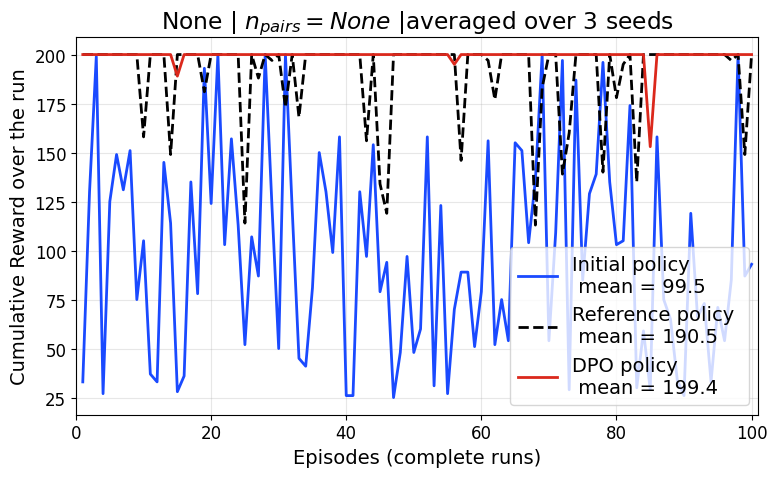

-------------------------------------
Evaluating pi_1, pi_2 and pi_DPO with seed=42, beta=0.5 over 100 episodes
Evaluations over 100 episodes using the evalutation seed 74
pi_1(42)    	 mean reward: 	 189.14 ± 31.50
pi_INIT(42) 	 mean reward: 	 112.15 ± 55.85
pi_DPO(42)  	 mean reward: 	 199.67 ± 2.83


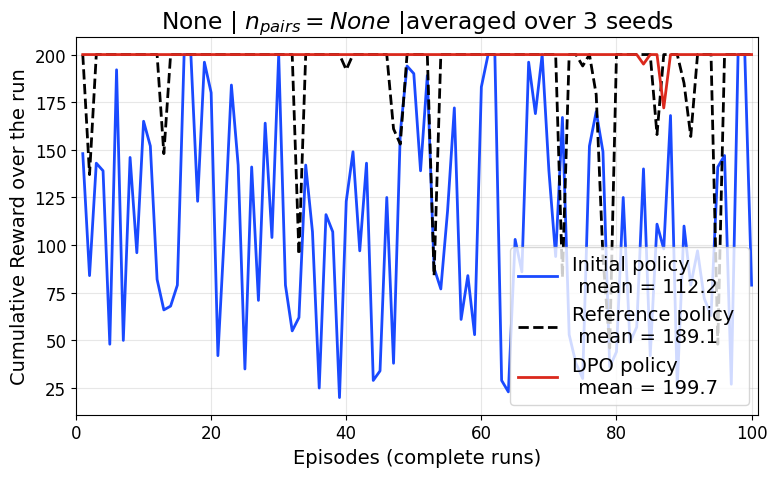

-------------------------------------
Evaluating pi_1, pi_2 and pi_DPO with seed=100, beta=0.5 over 100 episodes
Evaluations over 100 episodes using the evalutation seed 132
pi_1(100)    	 mean reward: 	 190.59 ± 25.06
pi_INIT(100) 	 mean reward: 	 111.08 ± 51.77
pi_DPO(100)  	 mean reward: 	 199.62 ± 3.78


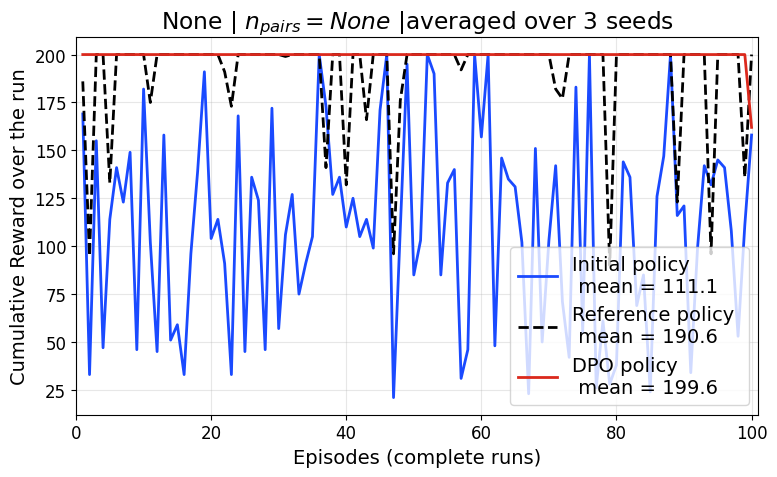

-------------------------------------


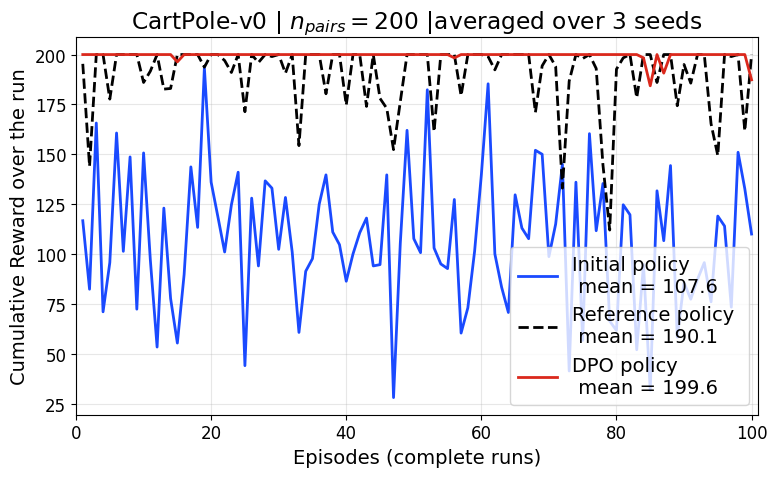

In [12]:
pi1_rewards_mean=np.zeros(n_eval)
pi2_rewards_mean=np.zeros(n_eval)
pi_dpo_rewards_mean=np.zeros(n_eval)
for seed, (pi_1, pi_2), pi_dpo in zip(seeds_list, Policy_list, Policy_DPO_list):
  print(f"Evaluating pi_1, pi_2 and pi_DPO with {seed=}, {beta=} over {n_eval} episodes")
  # Evaluate the policies
  seed_eval = seed+32
  _, pi1_rewards     = evaluate_policy(pi_1,        env, n_episodes=n_eval, seed=seed_eval)
  _, pi_dpo_rewards   = evaluate_policy(pi_dpo,     env, n_episodes=n_eval, seed=seed_eval)
  _, pi2_rewards      = evaluate_policy(pi_2,       env, n_episodes=n_eval, seed=seed_eval)
  print(f"Evaluations over {n_eval} episodes using the evalutation seed {seed_eval}")
  print(f"pi_1({seed})    \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
  print(f"pi_INIT({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
  print(f"pi_DPO({seed})  \t mean reward: \t {np.mean(pi_dpo_rewards):.2f} ± {np.std(pi_dpo_rewards):.2f}")

  pi1_rewards_mean+=pi1_rewards
  pi2_rewards_mean+=pi2_rewards
  pi_dpo_rewards_mean+=pi_dpo_rewards


  plot_scores_RLHF(
      pi2_rewards,
      pi1_rewards,
      pi_dpo_rewards,
      algo="DPO"
  )
  print("-------------------------------------")
plot_scores_RLHF(
      pi2_rewards_mean/3,
      pi1_rewards_mean/3,
      pi_dpo_rewards_mean/3,
      algo="DPO",save=True, n_pair=n_pairs, env_name=env_name
  )
